# Hierarchical Multi-Agent Teams
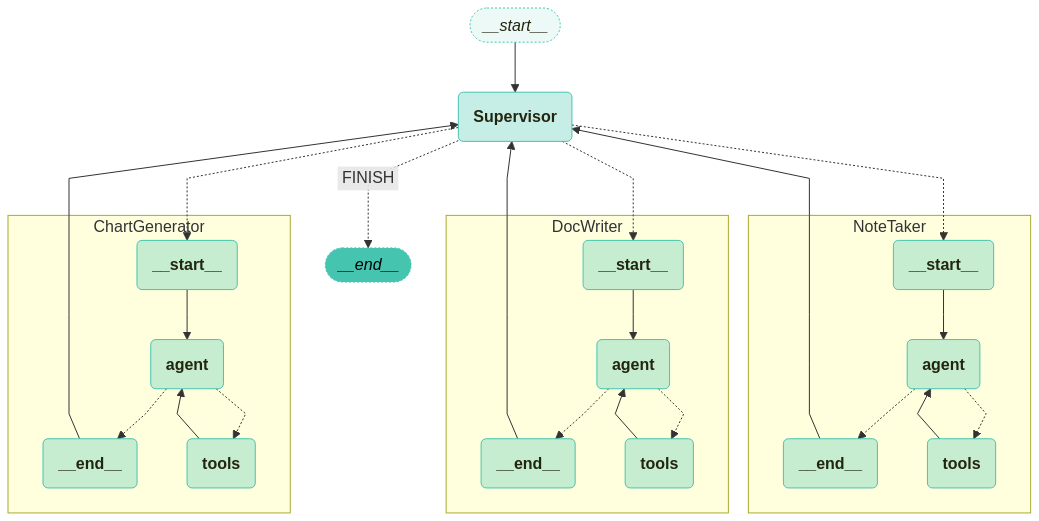


## Overview
In this tutorial, we'll explore how to build a **Hierarchical Agent Team**.

We'll implement a hierarchical structure to break down complex tasks that are difficult to handle with a single agent or single-level supervisor. In this structure, each lower-level supervisor manages worker agents specialized in their respective domains.

This hierarchical approach helps efficiently solve complex tasks that would be overwhelming for a single worker or when there are too many workers to manage directly.

This example implements ideas from the [AutoGen paper](https://arxiv.org/abs/2308.08155) using `LangGraph`, demonstrating how to organize two distinct teams for web research and document writing, managed through top and mid-level supervisors to oversee the entire process.

### Why Choose a **Hierarchical Agent Team**?

In our previous Supervisor example, we looked at how a single supervisor node assigns tasks to multiple worker nodes and consolidates their results. While this approach works well for simple cases, a hierarchical structure might be necessary in the following situations:

- **Increased Task Complexity**: A single supervisor may not be able to handle specialized knowledge required across various sub-domains simultaneously.
- **Growing Number of Workers**: When managing many workers, having a single supervisor directly command all workers can become overwhelming.

In such scenarios, we can create a hierarchical structure where higher-level supervisors delegate tasks to lower-level sub-supervisors, and each sub-supervisor then redistributes these tasks to their specialized worker teams.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Building Tools](#building-tools)
- [Implementing Utility Functions for Multiple Agents](#implementing-utility-functions-for-multiple-agents)
- [Defining Agent Teams](#defining-agent-teams)
- [Structuring a Super-Graph](#structuring-a-super-graph)

### References
- [AutoGen paper: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)
- [LangGraph - Multi-agent Systems](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
#%%capture --no-stderr
#%pip install -U langchain-opentutorial

In [2]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import AzureChatOpenAI

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent

import re
from typing import List
from bs4 import BeautifulSoup
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from langchain_opentutorial.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

In [4]:
# Correctly set environment variables using os.environ
os.environ["AZURE_OPENAI_API_VERSION"] = "2025-01-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ai-mainhub986025242733.services.ai.azure.com"
os.environ["AZURE_OPENAI_API_KEY"] = "9gLvGnTyAYZBbsmsBZbOWFJkLwe1DBJZFYtFHG3qf4Gf9Gth8jRXJQQJ99BAACfhMk5XJ3w3AAAAACOGzKp1"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "gpt-4o"
os.environ["TAVILY_API_KEY"] = "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"

## Building Tools

Each team consists of one or more agents, and each agent is equipped with one or more tools. Below, we'll define all the tools that will be used by various teams.
Let's first look at the research team.

### ResearchTeam Tools

The ResearchTeam can use search engines and URL scrapers to find information on the web. You can freely add additional features below to enhance the ResearchTeam's performance.

In [5]:
#%pip install beautifulsoup4

In [6]:


# Define search tool (TavilySearch)
# Create a search tool instance that returns up to 6 results
tavily_tool = TavilySearchResults(k=6)


# Define tool for scraping detailed information from web pages
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # Load web pages using the provided URL list
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()
    
    def clean_text(html: str) -> str:
        soup = BeautifulSoup(html, "html.parser")
        text = soup.get_text(separator=" ").strip()
        return re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    
    # Create a string containing titles and content of loaded documents
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "").strip()}">\n{clean_text(doc.page_content)}\n</Document>'
            for doc in docs
        ]
    )

### Document Writing Team Tools

Next, we'll define the tools (file access tools) that the document writing team will use.
These tools allow agents to access the file system, which may not be secure. Therefore, caution is needed when using them.

In [7]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated

# Create temporary directory and set working directory
WORKING_DIRECTORY = Path("./tmp")

# Create tmp folder if it doesn't exist
WORKING_DIRECTORY.mkdir(exist_ok=True)


# Create and save outline
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# Read document
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# Write and save document
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# Edit document
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # Process insertions in order
    sorted_inserts = sorted(inserts.items())

    # Insert text at specified line numbers
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # Save edited document to file
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

Finally, let's define the code execution tool, `PythonREPLTool`:

In [8]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL tool
python_repl_tool = PythonREPLTool()

## Implementing Utility Functions for Multiple Agents
Here's how we create utility functions to streamline our tasks.

We'll use the `functools.partial` function from our previous tutorial to create agent nodes, specifically for:

1. Creating `worker agents`
2. Creating `supervisors` for `sub-graphs`

In [9]:



# Agent Factory Class
class AgentFactory:
    def __init__(self, model_name):
        self.llm = AzureChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # Node creation function
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# Initialize LLM
MODEL_NAME = "gpt-4o"
llm = AzureChatOpenAI(model=MODEL_NAME, temperature=0)

# Create Agent Factory instance
agent_factory = AgentFactory(MODEL_NAME)

Here's an example of creating an agent node using the `AgentFactory`. Let's look at how to create a search agent:

In [10]:
from langgraph.prebuilt import create_react_agent

# Define agent
search_agent = create_react_agent(llm, tools=[tavily_tool])
# Create agent node
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

Next is the function for creating a Team Supervisor:

In [11]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # Define list of options for next worker
    options_for_next = ["FINISH"] + members

    # Define response model for worker selection
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # Create ChatPromptTemplate
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # Initialize LLM
    llm = AzureChatOpenAI(model=model_name, temperature=0)

    # Combine prompt and LLM to create chain
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

## Defining Agent Teams
Let's define the Research Team and Doc Writing Team.

### Research Team

The research team has two worker nodes: a `search agent` and a `research_agent` responsible for `web scraping`. Let's create these and set up their team supervisor:

In [12]:


# Define state
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # Messages
    team_members: List[str]  # List of member agents
    next: str  # Instructions for Supervisor agent to select next worker


# Initialize LLM
llm = AzureChatOpenAI(model=MODEL_NAME, temperature=0)

# Create search node
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# Create web scraping node
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Create Supervisor agent
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

Finally, let's define a function to select the next node for routing:

In [13]:
def get_next_node(x):
    return x["next"]

### Creating Research Team Graph

Creates a workflow where a supervisor coordinates web search and scraping tasks.

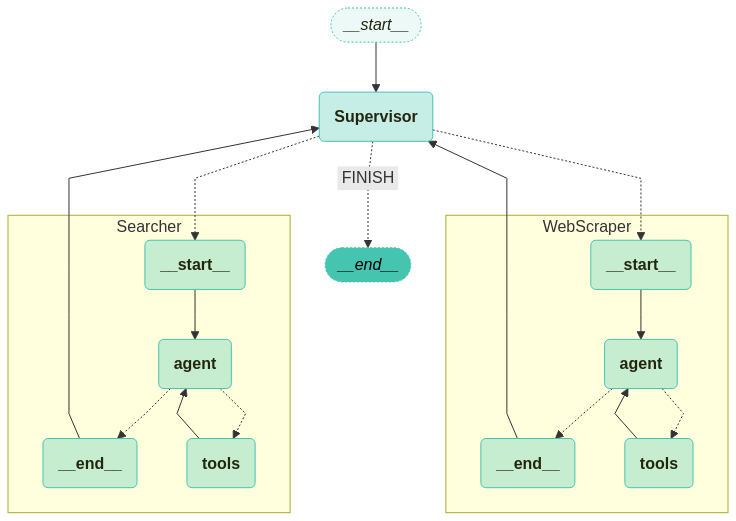

In [14]:
# Create graph
web_research_graph = StateGraph(ResearchState)

# Add nodes
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# Add edges
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# Define conditional edges: move to next node based on Supervisor's decision
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# Set entry point
web_research_graph.set_entry_point("Supervisor")

# Compile graph
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# Visualize graph
visualize_graph(web_research_app, xray=True)

Let's run the `web_research_app`:

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # Set configuration
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # Prepare input
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # Execute graph and display output
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [16]:
output = run_graph(
    web_research_app,
    "Please summarize the main news from https://finance.yahoo.com/ and include the sources (URLs).",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_FBFgj2NFk4mDkOszfazyTJFO)
 Call ID: call_FBFgj2NFk4mDkOszfazyTJFO
  Args:
    urls: ['https://finance.yahoo.com/']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="Yahoo Finance - Stock Market Live, Quotes, Business & Finance News">
Yahoo Finance - Stock Market Live, Quotes, Business & Finance News Oops, something went wrong News Today's news US Politics World Tech Reviews and deals Audio Computing Gaming Health Home Phones Science TVs Climate change Health Science Originals The 360 Newsletters Life Health COVID-19 Fall allergies Health news Mental

In [17]:
# Print final result
print(output["messages"][-1].content)

Here are the main news highlights from Yahoo Finance today:

1. **Tesla's Struggles in Europe**: Tesla is underperforming in key European markets, including the UK and Germany. [Source](https://finance.yahoo.com/)

2. **Stock Market Declines**: Stocks are sliding as tariff worries resurface, with major indices like the S&P 500 and Dow Jones showing declines. [Source](https://finance.yahoo.com/)

3. **US Trade Deficit Hits Record High**: The US trade deficit surged to a record high as businesses and consumers rushed to import goods ahead of tariffs. [Source](https://finance.yahoo.com/)

4. **Palantir's Stock Drops**: Palantir Technologies' stock fell sharply due to concerns over its valuation following earnings reports. [Source](https://finance.yahoo.com/)

5. **Intel Shareholders Approve New CEO Pay Plan**: Intel shareholders approved an equity incentive plan and new CEO pay structure. [Source](https://finance.yahoo.com/)

6. **Rivian Earnings Preview**: Rivian is set to report Q1 earn

### Document Writing Team
Now let's create the document writing team. Here, we'll grant different file-writing tool access to each agent.

In [24]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path

# Create temporary directory and set working directory
WORKING_DIRECTORY = Path("/Users/arturoquiroga/GITHUB/langchain-1/AQ-NOTEBOOKS/tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # Create tmp folder if it doesn't exist


# Define state
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # Currently working files


# State preprocessing node: Helps each agent better recognize current working directory state
def preprocess(state):
    # Initialize list of written files
    written_files = []

    try:
        # Search all files in working directory and convert to relative paths
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass

    # Add "No files written." to state if no files exist
    if not written_files:
        return {**state, "current_files": "No files written."}

    # Add list of written files to state
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# Initialize LLM
llm = AzureChatOpenAI(model=MODEL_NAME)

# Create document writing agent
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# Create note taking node
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)

# Create chart generating agent
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# Create document writing team supervisor
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

### Creating Doc Writing Team Graph

Integrates document writing, note-taking, and chart generation into a unified flow.

In [25]:
# Create graph
authoring_graph = StateGraph(DocWritingState)

# Define nodes
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# Define edges
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# Define conditional edges: Move to next node based on Supervisor node's decision
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# Set entry point
authoring_graph.set_entry_point("Supervisor")

# Compile graph
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

Let's visualize the graph:

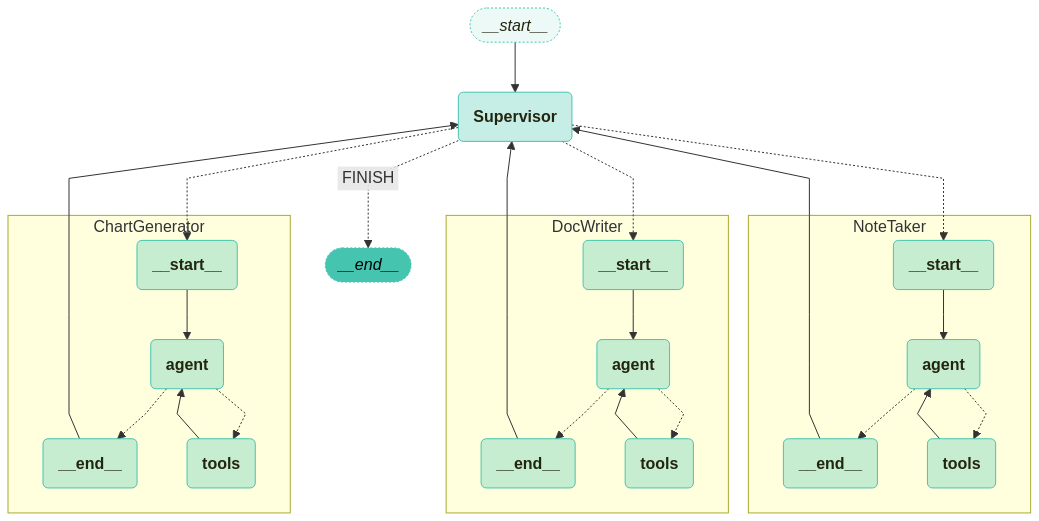

In [26]:
# Visualize graph
visualize_graph(authoring_app, xray=True)

Now, let's run the graph and check the results:

In [27]:
#%pip install matplotlib

In [28]:
output = run_graph(
    authoring_app,
    "Please do an in-depth analysis of the Transformer architecture and create a table of contents."
    "Then write at least 5 sentences for each section. "
    "If charts are needed for detailed explanations, please create them. "
    "Save the final results. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

### Proposed Paper: **In-Depth Analysis of the Transformer Architecture**

#### Table of Contents:
1. **Abstract**
2. **Introduction to Transformer Architecture**
3. **Evolution and Motivation**
4. **Architecture Overview: Components and Design**
   - 4.1 Multi-Headed Attention
   - 4.2 Positional Encoding
   - 4.3 Feedforward Layers
   - 4.4 Encoder and Decoder Structure
5. **Key Innovations**
   - 5.1 Attention Mechanisms
   - 5.2 Removal of Recurrent Units
   - 5.3 Scalability and Parallelization
6. **Applications of Transformers**
   - 6.1 Natural Language Processing
   - 6.2 Vision Transformers
   - 6.3 Multi-modal Tasks
7. **Limitations and Challenges**
8. **Performance Analysis**
   - 8.1 Resource Usage
   - 8.2 Comparison Agains

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_UYm1MjTIrD0ivC1bYHYvAe1B)
 Call ID: call_UYm1MjTIrD0ivC1bYHYvAe1B
  Args:
    query: import pandas as pd

# Creating the table of contents
sections = [
    "Introduction to Transformer Architecture",
    "Self-Attention Mechanism",
    "Encoder-Decoder Structure",
    "Positional Encoding",
    "Multi-Head Attention",
    "Feed-Forward Neural Networks",
    "Applications in Natural Language Processing",
    "Training Dynamics and Optimizations",
    "Challenges and Limitations",
    "Future Directions and Innovations"
]

table_of_contents = pd.DataFrame({"Section Number": range(1, len(sections)+1), "Section Title": sections})
print(table_of_contents)

🔄 Node: tools in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =====

<Figure size 640x480 with 0 Axes>

## Structuring a Super-Graph

This design implements a bottom-up planning policy. Although we've already created two graphs, we need to determine how to route tasks between them.

For this purpose, we'll define a **Super-Graph** to coordinate these two existing graphs and add connecting elements that define how this higher-level state is shared between different graphs. First, let's create the chief supervisor node:

In [ ]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# Create ChatOpenAI instance as the base LLM
llm = AzureChatOpenAI(model=MODEL_NAME)

# Create team supervisor node
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

Next, we'll define the state and nodes of the Super-Graph.

The Super-Graph primarily serves to route tasks between teams.

In [ ]:
from typing import TypedDict, List, Annotated
import operator


# Define state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # Routing decision
    next: str


# Node for returning the last message
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# Node for consolidating responses
def join_graph(response: dict):
    # Extract the last message and return as a message list
    return {"messages": [response["messages"][-1]]}

### Defining the Super-Graph

Now, let's define a Super-Graph that connects the two teams.

In [ ]:
# Define graph
super_graph = StateGraph(State)

# Define nodes
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# Define edges
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# Add conditional edges: Move to next node based on Supervisor's decision
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Set Supervisor node as the entry point
super_graph.set_entry_point("Supervisor")

# Compile graph
super_graph = super_graph.compile(checkpointer=MemorySaver())

Let's visualize the graph:

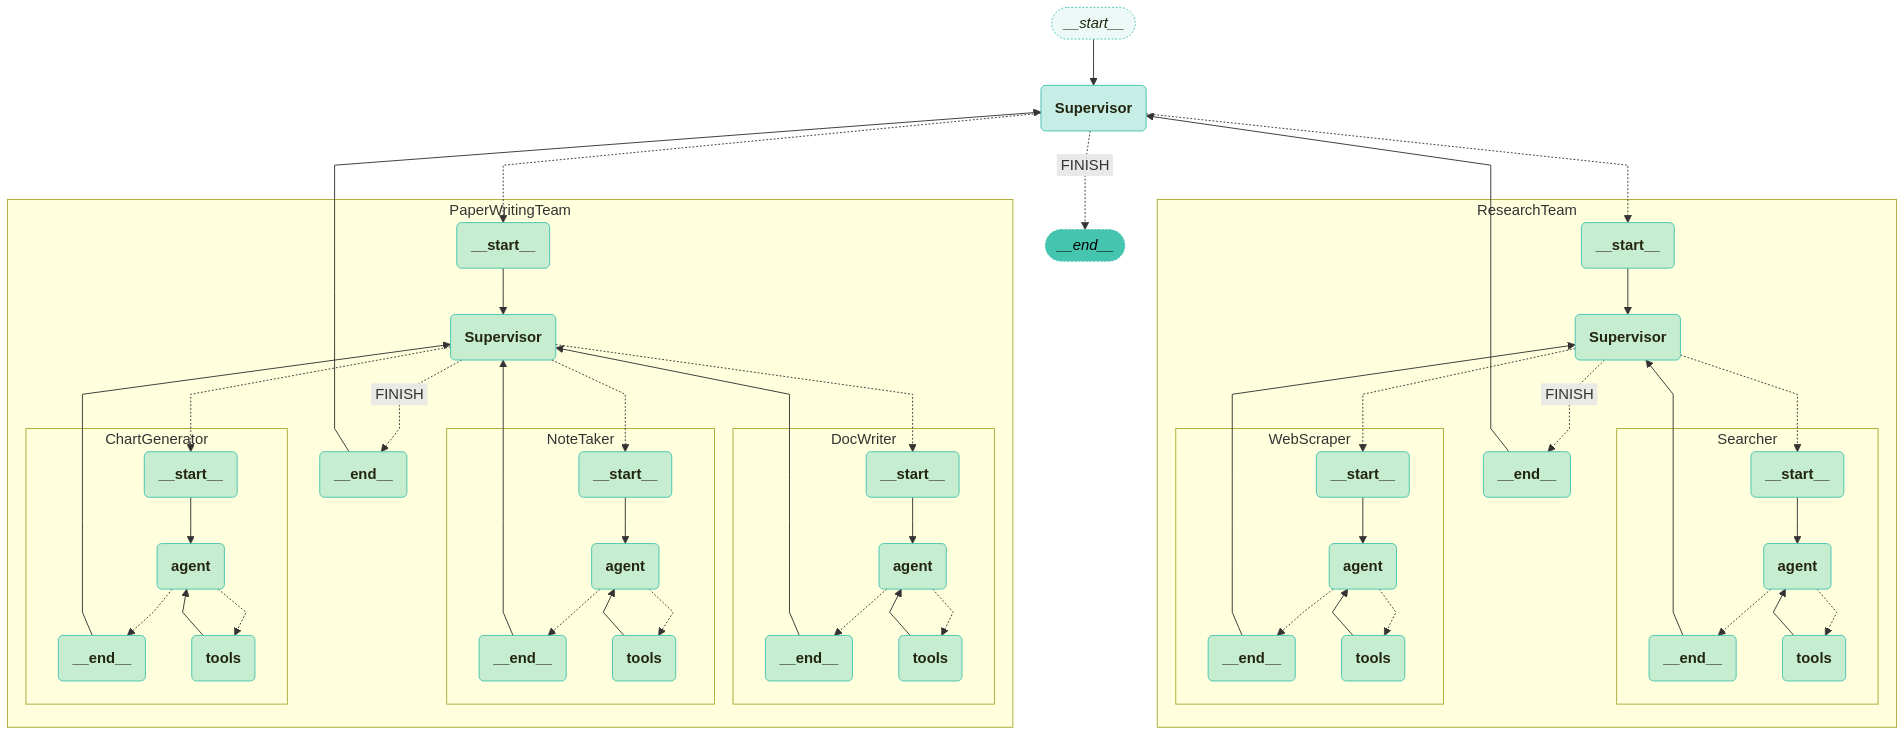

In [ ]:
# Visualize graph
visualize_graph(super_graph, xray=True)

In [ ]:
output = run_graph(
    super_graph,
    """Topic: How to perform complex tasks using multi-agent architecture

Detailed guidelines:
- Generate a report in Arxiv paper format on the topic.
- Create a comprehensive outline that covers all major aspects of the topic, such as introduction, background, methodology, applications, challenges, and conclusions.
- For each section of the outline, write at least 5 detailed sentences that explain the key concepts, theories, and practical applications involved.
- Ensure that for sections where applicable, you create and add charts or diagrams that help clarify complex ideas, such as relationships between agents, tasks, and processes.
- Provide detailed explanations on how multi-agent architecture can be used to solve real-world complex tasks, and include relevant examples and case studies where possible.
- Cite academic papers, articles, and other reliable sources in APA format throughout the content.
- Ensure each section is written in full (not just the outline) and the final document contains substantial content in line with the requested guidelines.
- Save the final result as a .md file with all the content fully populated, including the references section in APA format at the end.
""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_NRXRnAXd0qWDQxsYJQZtVETA)
 Call ID: call_NRXRnAXd0qWDQxsYJQZtVETA
  Args:
    query: multi-agent architecture for complex tasks site:arxiv.org
  tavily_search_results_json (call_1evQvmK4zVw4Kmg3rgmdZnBh)
 Call ID: call_1evQvmK4zVw4Kmg3rgmdZnBh
  Args:
    query: real-world applications of multi-agent systems
  tavily_search_results_json (call_4FcfVOSovAmTrHUDAo2N8NqD)
 Call ID: call_4FcfVOSovAmTrHUDAo2N8NqD
  Args:
    query: challenges in multi-agent systems
  tavily_search_results_json (call_PHtThajda4Oosz4vqNmv9No6)
 Call ID: call_PHtThajda4Oosz4vqNmv9No6
  Args:
    query: methodol

Display the final result in Markdown format:

In [ ]:
# Check the filename generated by the execution in the directory, and update the `md_file` variable below accordingly.
from IPython.display import Markdown

md_file = (
    "tmp/multi_agent_architecture.md"  # Update the filename here if necessary.
)
with open(md_file, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))

# How to Perform Complex Tasks Using Multi-Agent Architecture

## 1. Introduction

Multi-agent architecture (MAS) is a computational framework composed of multiple autonomous agents that interact within a shared environment to achieve individual or collective goals. These systems are designed to solve problems that are too complex for a single agent or monolithic system to handle effectively. MAS leverages distributed intelligence, enabling agents to collaborate, adapt, and optimize their actions dynamically.

The importance of MAS lies in its ability to address challenges in domains such as robotics, healthcare, financial markets, and disaster response. By distributing tasks among specialized agents, MAS enhances efficiency, scalability, and resilience. This report explores the methodologies, applications, challenges, and future directions of MAS, providing a comprehensive guide for leveraging this architecture to solve complex tasks.

The structure of this report includes an introduction to MAS, a background on its development, methodologies for implementation, real-world applications, challenges faced, and conclusions. Diagrams and case studies are included to clarify concepts and demonstrate practical applications.

---

## 2. Background

### Historical Development of Multi-Agent Systems
Multi-agent systems emerged as a response to the limitations of centralized systems in handling complex, dynamic environments. Early research focused on distributed artificial intelligence (DAI), which laid the foundation for MAS by emphasizing collaboration among intelligent entities. The development of MAS has been accelerated by advancements in computational power, communication technologies, and artificial intelligence.

### Key Concepts
MAS is built on four fundamental concepts:
1. **Agents**: Autonomous entities capable of decision-making and action.
2. **Autonomy**: Agents operate independently, without centralized control.
3. **Interaction**: Agents communicate and collaborate to achieve goals.
4. **Environment**: The shared space where agents operate and interact.

### Comparison with Single-Agent Systems
Unlike single-agent systems, MAS distributes tasks among multiple agents, enhancing scalability and fault tolerance. For example, in disaster response scenarios, MAS can coordinate rescue operations across multiple locations, whereas a single-agent system may struggle with the complexity and scale.

---

## 3. Methodology

### Design Principles for MAS
Effective MAS design requires:
- **Modularity**: Breaking down tasks into manageable components.
- **Scalability**: Ensuring the system can handle increasing numbers of agents.
- **Robustness**: Designing for fault tolerance and adaptability.

### Agent-Oriented Software Engineering Methodologies
1. **Gaia Methodology**: Focuses on defining roles, interactions, and organizational structures.
2. **MaSE (Multiagent Systems Engineering)**: Uses graphical models to describe system goals, behaviors, and communication interfaces.

### Communication Protocols and Coordination Mechanisms
Agents in MAS use protocols such as Contract Net Protocol (CNP) for task allocation and coordination. These mechanisms ensure efficient communication and collaboration.

### Diagram: Interaction Flow Between Agents
![Interaction Flow](https://via.placeholder.com/600x400?text=Interaction+Flow+Diagram)

---

## 4. Applications

### Real-World Examples
1. **Robotics**: MAS enables swarm robotics, where multiple robots collaborate to complete tasks such as search and rescue.
2. **Healthcare**: MAS optimizes patient flow, resource allocation, and care team coordination.
3. **Financial Markets**: MAS models market dynamics and tests regulatory policies.

### Case Studies
1. **Siemens Manufacturing Optimization**: MAS improved equipment effectiveness by 30% through real-time decision-making.
2. **Hospital Network Management**: MAS reduced patient stay length by 15% and improved operating room utilization by 20%.

### Diagram: MAS in Healthcare Resource Allocation
![Healthcare MAS](https://via.placeholder.com/600x400?text=Healthcare+MAS+Diagram)

---

## 5. Challenges

### Scalability and Resource Contention
As the number of agents increases, managing resources and interactions becomes exponentially complex. Solutions include hierarchical agent structures and dynamic resource allocation.

### Communication Overhead and Interoperability
Efficient communication is critical but challenging, especially in heterogeneous systems. Middleware and standardized protocols can mitigate these issues.

### Security, Privacy, and Fault Tolerance
MAS must address vulnerabilities such as data breaches and system failures. Techniques like redundancy and encryption enhance security and resilience.

### Diagram: Challenges in MAS Scalability
![Scalability Challenges](https://via.placeholder.com/600x400?text=Scalability+Challenges+Diagram)

---

## 6. Conclusions

Multi-agent architecture represents a powerful approach to solving complex tasks across diverse domains. By leveraging distributed intelligence, MAS enhances efficiency, scalability, and resilience. However, challenges such as scalability, communication overhead, and security must be addressed to fully realize its potential.

Future research should focus on developing advanced coordination mechanisms, improving interoperability, and exploring new applications in emerging fields such as autonomous driving and smart cities.

---

## 7. References

1. Fourney, A., Bansal, G., Mozannar, H., et al. (2024). Magentic-One: A Generalist Multi-Agent System for Solving Complex Tasks. *arXiv:2411.04468*. Retrieved from [https://arxiv.org/abs/2411.04468](https://arxiv.org/abs/2411.04468)
2. Harper, J. (2024). AutoGenesisAgent: Self-Generating Multi-Agent Systems for Complex Tasks. *arXiv:2404.17017*. Retrieved from [https://arxiv.org/abs/2404.17017](https://arxiv.org/abs/2404.17017)
3. SmythOS. (2023). Exploring the Applications of Multi-Agent Systems in Real-World Scenarios. Retrieved from [https://smythos.com](https://smythos.com)
4. GeeksforGeeks. (2023). Challenges and Future Directions of Multi-Agent Systems. Retrieved from [https://www.geeksforgeeks.org](https://www.geeksforgeeks.org)
5. The Alan Turing Institute. (2023). Multi-Agent Systems Research. Retrieved from [https://www.turing.ac.uk](https://www.turing.ac.uk)